In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
print("gpu available:", torch.cuda.is_available())


gpu available: True


In [47]:
def FDM(m, c, k, u0, v0, t_end, n_steps):
    # 問題設定
    """
    m : 質量 [kg]
    c : 減衰係数 [N.s/m]  
    k : ばね定数 [N/m]
    u0 : 初期変位 [m]
    v0 : 初期速度 [m/s]
    t_end : 計算時間 [s]
    n_steps : ステップ数
    """

    # 時間ベクトルと初期値
    t = np.linspace(0, t_end, n_steps)
    u_num = np.zeros_like(t)
    v_num = np.zeros_like(t)
    u_num[0] = u0
    v_num[0] = v0

    # 有限要素法
    dt = t[1] - t[0]
    for i in range(n_steps-1):
        acc = (k*u_num[i] + c*v_num[i]) / -m  # 加速度
        v_num[i+1] = v_num[i] + acc*dt        # 速度
        u_num[i+1] = u_num[i] + v_num[i+1]*dt # 変位

    # 理論解
    zeta = c / (2 * np.sqrt(k*m))  # 減衰比
    omega_n = np.sqrt(k/m)         # 固有円振動数
    omega_d = omega_n * np.sqrt(1 - zeta**2) # 減衰円振動数
    C1 = u0
    C2 = v0 / omega_d
    u_th = np.exp(-zeta*omega_n*t) * (C1*np.cos(omega_d*t) + C2*np.sin(omega_d*t))

    return t, u_num, u_th


In [48]:
def early_Stopping(loss_values, patience=10, delta=0):
    """Early stopping to monitor the loss value
    
    Args:
        loss_values (list): The list of loss values
        patience (int, optional): How many epochs to wait for improvement before stopping. Defaults to 10.
        delta (float, optional): Minimum change in loss value to qualify as an improvement. Defaults to 0.
        
    Returns:
        bool: True if we should stop training, False otherwise
    """
    if len(loss_values) <= patience:
        return False
    
    # Calculate the difference between current and minimum loss
    minimum = np.min(loss_values[:-patience])
    current = loss_values[-1]
    diff = abs(current - minimum)
    
    if diff < delta:
        return True  # Loss did not improve enough, stop training
    else:
        return False  # Loss improved, continue training


In [49]:
class PhysicsInformedNNs(nn.Module):
    def __init__(self, n_input, n_output, n_neuron, n_layer, epochs, act_fn='tanh'):
        """
        Neural Networksの作成
        """
        super(PhysicsInformedNNs, self).__init__()
        self.n_input = n_input # 入力の数
        self.n_output = n_output # 出力の数
        self.n_neuron = n_neuron # 中間層のニューロンの数
        self.n_layer = n_layer # 中間層の数
        self.epochs = epochs # エポック数
        self.act_fn = getattr(F, act_fn)
        
        layers = []
        layers.append(nn.Linear(n_input, n_neuron)) # 一層目を作る
        layers.append(nn.Tanh() if act_fn == 'tanh' else nn.ReLU()) # ここで入力層-中間層-活性化関数 までできる
        
        for _ in range(n_layer - 1):
            """
            中間層をn_layer - 1個作る
            中間層-活性化関数-中間層-活性化関数-・・・とする
            """
            layers.append(nn.Linear(n_neuron, n_neuron))
            layers.append(nn.Tanh() if act_fn == 'tanh' else nn.ReLU())
        
        layers.append(nn.Linear(n_neuron, n_output)) # 出力層をくっつける
        self.layers = nn.Sequential(*layers) # self.layersに層構造を格納する
        
    def forward(self, t):
        """
        入力 t を受け取って、self.layersからの結果を出力する
        """
        return self.layers(t)
    
    def train_step(self, t_data, x_data, t_pinn, c, k, optimizer, loss_fn):
        """
        損失関数や学習の仕方などを定義する
        t_data, t_pinn はこのファイル内では時間が入っている
        """
        optimizer.zero_grad() # 勾配を0にリセットする
        
        """
        Neural Networkの部分
        """
        x_pred = self.forward(t_data) # forward関数にt_dataを入れて予測値x_predを受け取る。xは変位
        loss1 = loss_fn(x_pred, x_data) # 損失関数loss_fnで損失を計算してる
        """
        Physics Informedの部分
        """
        x_pred_pinn = self.forward(t_pinn) # forward関数にt_pinnを入れて予測値x_pred_pinnを受け取る
        dx_dt = torch.autograd.grad(x_pred_pinn.sum(), t_pinn, create_graph=True, allow_unused=True)[0] # xをtで微分する
        dx_dt2 = torch.autograd.grad(dx_dt.sum(), t_pinn, create_graph=True, allow_unused=True)[0] # dx/dtをtで微分する
        loss_physics = dx_dt2 + c * dx_dt + k * x_pred_pinn # 方程式の残差を計算する
        loss2 = loss_fn(loss_physics, torch.zeros_like(loss_physics)) # 方程式の残差は0が望ましいので方程式の残差と0ベクトルの損失を計算する
        """
        NN + PI = PINNs の部分
        """
        loss = loss1 + 3.0e-4 * loss2 # NN部分の損失とPINNs部分の損失を合わせて全体の損失とする。5.0e-4はスケール合わせ
        loss.backward() # 損失に対する勾配を計算する
        optimizer.step() # 計算された勾配に元図いて重みを更新する
        
        return loss, loss1, loss2, x_pred_pinn # 合計損失を返す
    
    def train(self, t, x, t_data, x_data, t_pinn, c:float, k:float, optimizer, loss_fn, early_stopping):
        # テンソルをデバイスに移動
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        t_data = t_data.to(device)
        x_data = x_data.to(device)
        t_pinn = t_pinn.to(device)

        loss_values = []
        x_preds = []
        for i in range(self.epochs):
            loss, loss1, loss2, x_pred = self.train_step(t_data, x_data, t_pinn, c, k, optimizer, loss_fn)
            loss_values.append(loss.item()) # train_stepでlossを計算して、epoch毎に保存する
            x_preds.append(x_pred.cpu())
            if i % 1000 == 0:
                print('epochs:', i, 'Loss:', loss.item(), 'loss1:', loss1.item(), 'loss2:', loss2.item())
            if early_stopping(loss_values):
                break
        #self.eval()
        return loss_values, x_preds


epochs: 0 Loss: 0.22320552170276642 loss1: 0.22305302321910858 loss2: 0.5083154439926147
epochs: 1000 Loss: 0.08545464277267456 loss1: 0.08491680026054382 loss2: 1.7928003072738647
epochs: 2000 Loss: 0.04737941548228264 loss1: 0.047088753432035446 loss2: 0.9688761234283447
epochs: 3000 Loss: 0.0184660404920578 loss1: 0.01819864846765995 loss2: 0.8913043737411499
epochs: 4000 Loss: 0.0013582526007667184 loss1: 0.0011139109265059233 loss2: 0.8144723176956177


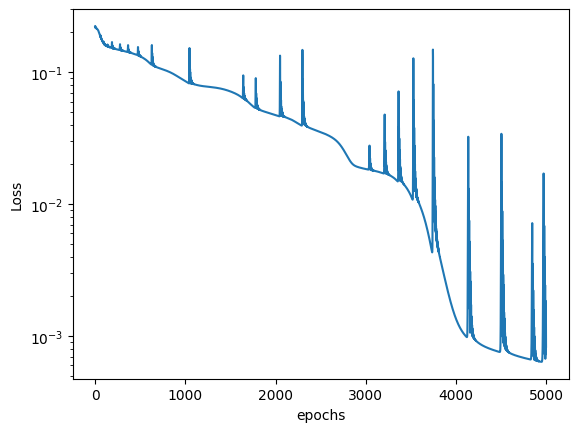

In [50]:
"""
手順
1. FDMで計算する
2. FDMの計算結果からランダムに5点を選び教師データとする

"""


m = 1.0
c = 0.2
k = 10.0
u0 = 1.0
v0 = 0.0
t_end = 10.0
n_steps = 1000

t, u_num, u_th = FDM(m, c, k, u0, v0, t_end, n_steps) # FEMで計算した時間刻みとFEMの解、グラフ用に一般解を出力する

# select_data = [0, 55, 230, 640, 900] # 適当に5点選ぶ、この場合0 ~ 1000までの間で選ぶ
select_data = np.linspace(0, n_steps-1, 500, dtype=int) # 0 ~ 1000までの間で等間隔に500点選ぶ
t_data = torch.from_numpy(t[select_data]).view(-1,1).to(torch.float32) # 5点抽出
x_data = torch.from_numpy(u_num[select_data]).view(-1,1).to(torch.float32) # 5点抽出
x = torch.from_numpy(u_num).view(-1,1).to(torch.float32)
t_pinn = torch.linspace(0, 10, 10000, requires_grad=True).view(-1,1).to(torch.float32)

n_input = 1
n_output = 1
n_neuron = 64
n_layer = 4
epochs = 5000

PINNs = PhysicsInformedNNs(n_input, n_output, n_neuron, n_layer, epochs)
optimizer = optim.AdamW(PINNs.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
early_stopping = early_Stopping
loss_values, x_preds = PINNs.train(t, u_num, t_data, x_data, t_pinn, c, k, optimizer, loss_fn, early_stopping)

plt.plot(np.arange(0, epochs, 1), loss_values)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

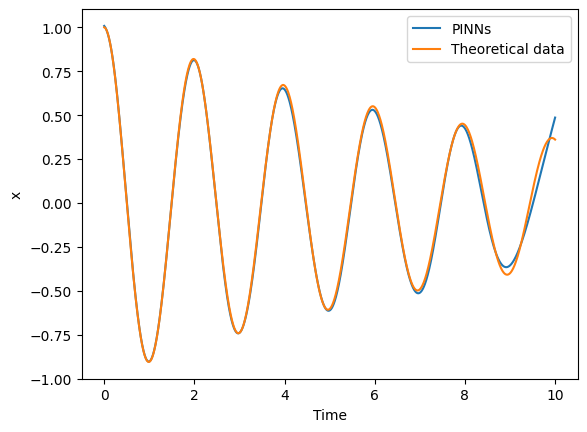

In [51]:
plt.plot(t_pinn.view(1, -1)[0].detach().numpy(), x_preds[-1].view(1,-1).detach().numpy()[0], label='PINNs')
# plt.scatter(t_data, x_data, label='Training data')
plt.plot(t, x, label='Theoretical data')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.show()